In [3]:
from numpy import sin, cos, pi, exp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
%matplotlib ipympl

# Configure default pyplot settings
plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

# Enable importing from modules in top-level directory
from sys import path
if path[0] != '..': path.insert(0, '..')

<img src="figures/NTNU_logo_vertical.svg" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Spectral Analysis of Noisy and/or Non-Stationary Signals signals


* **Course AIS2201 - Digital Signal Processing**
* **Week 39, 2025**
* **Lecturer: Kai Erik Hoff**

# Noisy Signals

* If there is random noise in the source signal $x[n]$, there will be random noise in the calculated periodogram

* Periodogram will be equal to $S_{xx}(f)$ *on average*, but individual calculated points $P_{xx}(f_m)$ may deviate significantly

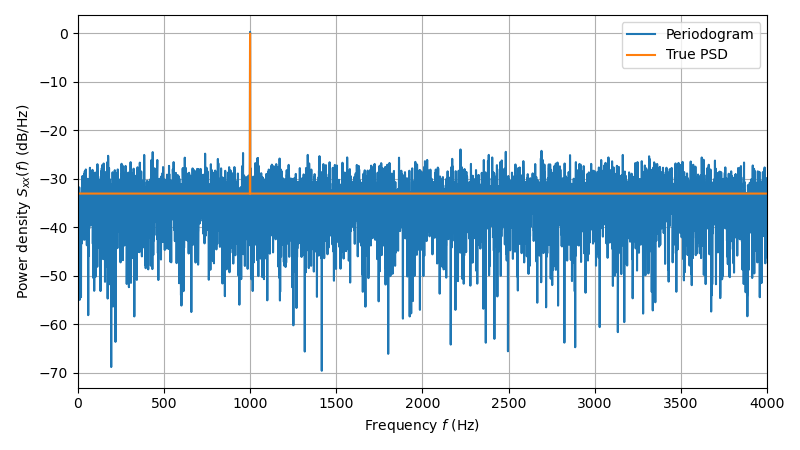

In [10]:
N = 12000 # Signal length in samples
Fs = 8000 # Sampling Frequency
F = 1000 # Signal Frequency

P_noise = 2
P_signal = 1


noise = np.random.randn(N)*np.sqrt(P_noise)
t = np.linspace(0, N/Fs, N, endpoint=False)
signal = cos(2*pi*F*t)*np.sqrt(P_signal*2)
xn = signal + noise


plt.close(5); plt.figure(5)
# Estimate PSD
f, P_xx = sig.periodogram(xn, fs=Fs, window='hamming')
plt.plot(f, 10*np.log10(P_xx),  label="Periodogram")

# Calculate true PSD
S_xx = np.ones(Fs//2+1)*P_noise/Fs*2
S_xx[F] += P_signal
plt.plot(np.arange(Fs//2+1), 10*np.log10(S_xx), label="True PSD")
plt.xlabel("Frequency $f$ (Hz)")
plt.ylabel("Power density $S_{xx}(f)$ (dB/Hz)")
plt.legend()



# Averaging Periodograms (aka. Welch's method)

* Sacrifices spectral resolution for reduced noise


* Computes the PSD of $M$ smaller signal windows, calculates the mean at each frequency

$$\hat{S}_{xx}(f_m) = \frac{1}{M} \sum_{k=0}^M P_{xx, \ k}(f_m) $$



* Can use overlapping windows to ensure "full" utilization of information contained in signal
    * A portion of the previous window is "re-used" in next window
    * $50\%$ overlap recommended. Very limited "return on investment" for overlapping more than $50\%$.
<img src="figures/window_overlap.svg" style="width: 80%; margin-left=100px" />

## Welch's Method using Python



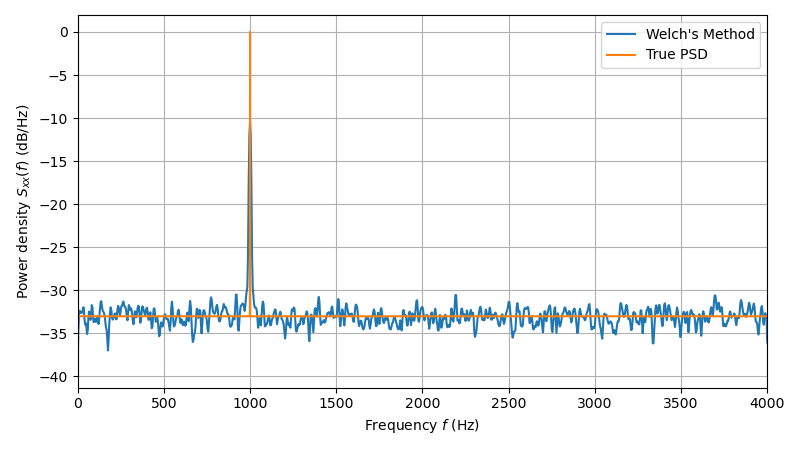

In [21]:
L = 12000 # Signal length in samples
Fs = 8000 # Sampling Frequency
F = 1000 # Signal Frequency
P_noise = 2 # Noise Power
P_signal = 1 # Signal Power

noise = np.random.randn(L)*np.sqrt(P_noise)
t = np.linspace(0, L/Fs, L, endpoint=False)
signal = cos(2*pi*F*t)*np.sqrt(P_signal*2)
xn = signal + noise

N = 1024 # Window length for PSD estimaton
overlap = 0.5 #50% overlap
pad_to = 2*N 

S_xx = np.zeros(pad_to//2+1)

n_start = 0
M = 0
while n_start < len(xn):
    f_m, P_xx = sig.periodogram(xn[n_start:n_start+N], fs=Fs, window='hamming', nfft=pad_to)
    S_xx += P_xx
    M += 1
    n_start += int(N*overlap)
S_xx /= M

plt.close(6); plt.figure(6)
plt.plot(f_m, 10*np.log10(S_xx), label="Welch's Method")

# Calculate true PSD
S_xx = np.ones(Fs//2+1)*P_noise/Fs*2
S_xx[F] += P_signal
plt.plot(np.arange(Fs//2+1), 10*np.log10(S_xx), label="True PSD")
plt.xlabel("Frequency $f$ (Hz)")
plt.ylabel("Power density $S_{xx}(f)$ (dB/Hz)")
plt.legend()


* PS: Can be accomplished in one line:
```Python
f_m, S_xx = sig.pwelch(xn, fs, window='hamming', nperseg=N, noverlap=N//2, nfft=N*2)
```

# Estimating SNR

* Assuming white noise, the noise level is indicated by the "noise floor" in the PSD

1. Calculate PSD of signal
2. Determine threshold separating noise and signal of interest
3. Calculate SNR
$$SNR = \frac{\text{Sum of } |X[m]|^2 \text{ samples above threshold}}{\text{Sum of } |X[m]|^2 \text{ samples below threshold}}$$

In [20]:
L = 12000 # Signal length in samples
Fs = 8000 # Sampling Frequency
F = 1000 # Signal Frequency
P_noise = 2 # Noise Power
P_signal = 1 # Signal Power

noise = np.random.randn(L)*np.sqrt(P_noise)
t = np.linspace(0, L/Fs, L, endpoint=False)
signal = cos(2*pi*F*t)*np.sqrt(P_signal*2)
xn = signal + noise


f_m, S_xx = sig.welch(xn, fs=Fs, window='hamming', nperseg=N, noverlap=N//2, nfft=N*2)

P_noise_est = 0
P_signal_est = 0

noise_floor = np.median(S_xx)

threshold = noise_floor*2 # - 30 dB determined through graphical analysis


for S_f in S_xx:
    if S_f > threshold:
        P_signal_est += S_f
    else:
        P_noise_est += S_f
        
SNR_est = P_signal_est/P_noise_est

print(f"{SNR_est = }\nSNR = {P_signal/P_noise}")

SNR_est = np.float64(0.5020015193316544)
SNR = 0.5


# Non-stationary signals






* Term for signals where the frequency content varies over time
    * Applies to most real-world signals

* Beneficial to calculate *how* the frequency content varies over time

* Proposed solution:
    1. Divide the signal into shorter segments
    2. Calculate the DFT of each segment
    3. Combine the frequency informationn from all segments into a komplex matrix $X[k, m]$
        - $m$ is frequency index
        - $k$ references time time for frequency components

# Short-time Fourier Transform (STFT)

$$\Large X[k, m] = \sum_{n=k\cdot N}^{(k+1)\cdot N}x[n]\cdot e^{-j2\pi \frac{n\cdot m}{N}}$$



* Determining window length boils down to a balancing time-domain precision against frequency-domain resolution

* Zero padding and overlapping windows are appropriate tools to get the most out of the signal samples $x[n]$

# Spectrograms

<img src="../continuous_signals/figures/Fig18_Spectrogram1.png" width="50%" style="margin-left:100px" />

* Sequence of PSD "Slices" based on STFT

## Teoriquiz 1:
* Et signalopptak har en lengde på $L=40\ 000$ sampler. Det er ønskelig å generere et spektrogram der vinduslengden brukt i til frekvensanalye er $N=1\ 000$ sampler, og for å øke antallet "frames" i spektrogramemet benytter vi $50\%$ overlapping av signalvinduene.
    * For hvor mange individuelle tidsintervall vil vi få utregnet spektralinnhold? Sagt på en annen måte: hva blir det totale antallet signalvindu vi henter fra signalet?
    
Antall separate vindu:

$$ \frac{L}{N} \cdot 2 +1 = \frac{40000}{1000} \cdot 2 + 1 = 81$$

## Spectrograms in Python
* Create a spectrogram which shows the frequency content of the audio file `"orca.wav"` over time.
    * Study how the various parameters affect the displayed spectrogram.

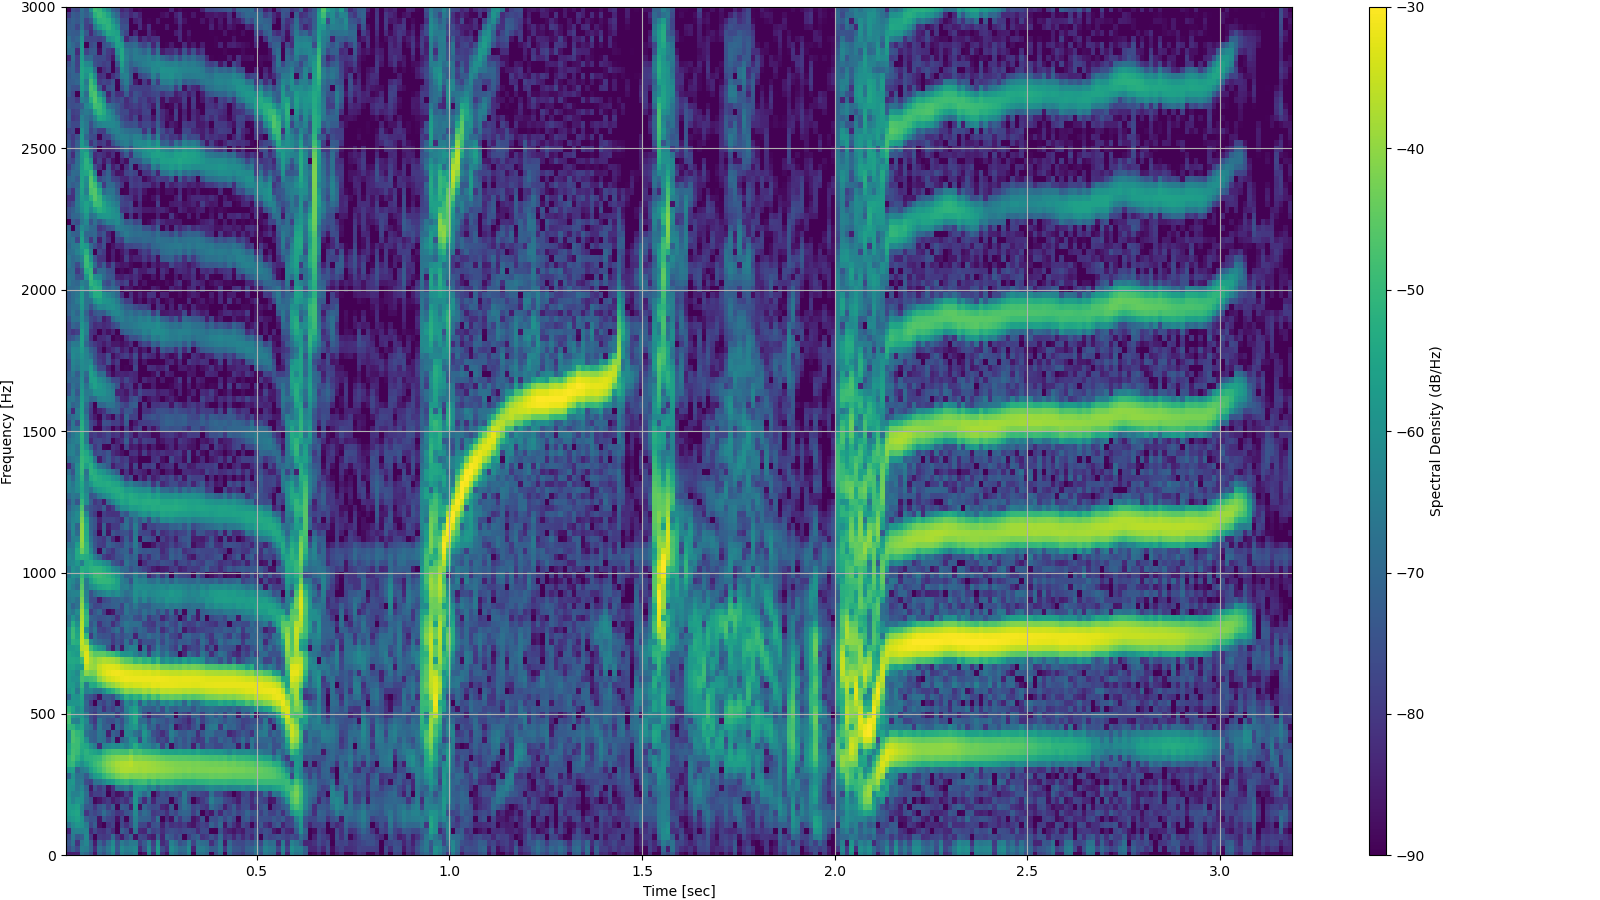

In [33]:
fs, data = wavfile.read(r'../data/orca.wav') # les audiofilen 'orca.wav' og lagre til variablene 'fs' og 'data'
xn = data/0x8000
N = 512

f_axis, t_axis, S_xx = sig.spectrogram(xn, 
                             fs, 
                             window = 'hamming', 
                             nperseg = N, 
                             noverlap = N//2, 
                             nfft = 2*N
                            )

plt.close(3);plt.figure(3, figsize=(16,9))

plt.pcolormesh(t_axis,            # Array med tidsstempel. Produsert av spectrogram()
               f_axis,            # Array med frekvenser. Produsert av spectrogram()
               10*np.log10(S_xx),  # Konvertering av spektrogrammatrise til logaritmisk skala
               vmax =-30,         # Høyeste dB-verdi på fargekartet
               vmin = -90,        # Laveste dB-verdi på fargekartet
               shading='auto'
               )
plt.colorbar(aspect=50, label=r'Spectral Density (dB/Hz)')

plt.ylim([0, 3000]) # Du kan justere på grensene i y-aksen dersom du vil inspisere en spesiell del av plottet
#plt.xlim([0, 300]) # Du kan justere på grensene i x-aksen dersom du vil inspisere en spesiell del av plottet
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.tight_layout(pad=0.1, w_pad=1.0, h_pad=1.0)
plt.show()
from IPython.display import Audio
Audio(xn, rate=fs)


# Anvendelser av spektrogram

* Kartlegging av interferens i radiosignal.
* Kartlegging av frekvensinnhold til et lydsignal / vibrasjonssignal o.l.
* Talegjenkjenning
    * Jeg vil sterkt anbefale [denne videoen](https://www.youtube.com/watch?v=N780rQIXSgc&t=448s) som viser hvordan spektrogram brukes til å pre-prosessere talesignal før en maskinlæingsalgoritme skal trenes til å gjenkjenne talesignalene.
* Mye mer...

# Spørsmål?